In [44]:
import pandas_profiling
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [7]:
df = pd.read_csv('order volume data.csv')
df.drop(columns=['picklist_count', 'vno'], inplace=True)
df = df[df['customer_category'] == 'RETAIL']
df.head()

,dist_id,dist_name,dispatch_date,bill_type,customer_category,line_items,qty,volume,amount
0,64,Aryan Wellness,2023-02-01,SN,RETAIL,3,3.0,1593.084310,1190.09
1,64,Aryan Wellness,2023-02-01,SN,RETAIL,8,34.0,900.678720,3758.44
2,64,Aryan Wellness,2023-02-01,SN,RETAIL,1,6.0,38.539200,177.84
3,64,Aryan Wellness,2023-02-01,SN,RETAIL,1,2.0,846.452700,195.80
4,64,Aryan Wellness,2023-02-01,SN,RETAIL,8,24.0,568.903844,2847.92


In [8]:
pandas_profiling.ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
df[(df['volume'] >= 859) & (df['volume'] <= 859.5+739)].shape[0]/df.shape[0]

0.1464355470076415

In [28]:
median = df['volume'].median()
q1 = df['volume'].quantile(0.25)
q3 = df['volume'].quantile(0.75)
iqr = q3 - q1
ll = q1 - 1.5*iqr
ul = q3 + 1.5*iqr

In [29]:
ll, ul

(-3136.44924825, 5863.97270175)

In [32]:
temp = df[df['volume']<5863.97270175]

<AxesSubplot:xlabel='volume', ylabel='Probability'>

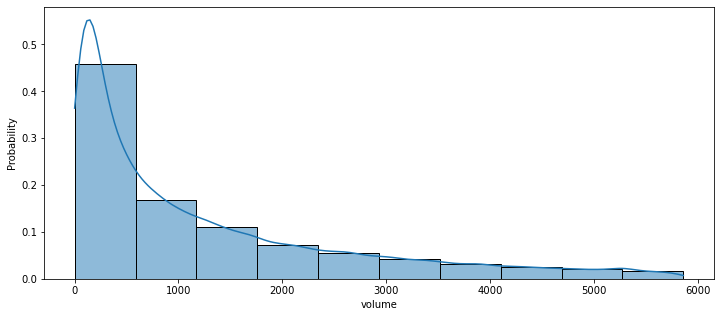

In [128]:
plt.figure(figsize=(12,5))
sns.histplot(temp['volume'], bins=10, kde=True, stat='probability')

In [50]:
df['volume'].fillna(df['volume'].median(), inplace=True)
df['amount'].fillna(df['amount'].median(), inplace=True)
df['qty'].fillna(df['qty'].median(), inplace=True)
df['line_items'].fillna(df['line_items'].median(), inplace=True)

In [68]:
rfm_df = df[['amount', 'volume', 'qty', 'line_items']]
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df.loc[:, ['volume']])

In [69]:
rfm_df_scaled

array([[-0.11882534],
       [-0.23608431],
       [-0.38208774],
       ...,
       [ 0.16641134],
       [-0.31171364],
       [-0.32849541]])

In [70]:
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

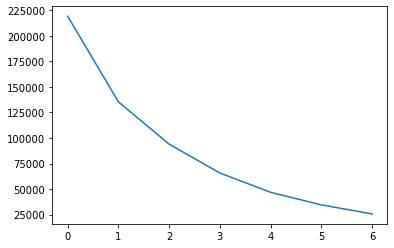

In [71]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

In [73]:
kmeans = KMeans(n_clusters=5, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=5)

In [75]:
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [76]:
rfm_df['cluster'] = kmeans.labels_

C:\Users\Rakesh Panigrahy\AppData\Local\Temp\ipykernel_26888\3729667138.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_df['cluster'] = kmeans.labels_


In [79]:
rfm_df['cluster'].value_counts()

0    321812
2     42292
1      3716
4       285
3        16
Name: cluster, dtype: int64

<AxesSubplot:xlabel='cluster', ylabel='volume'>

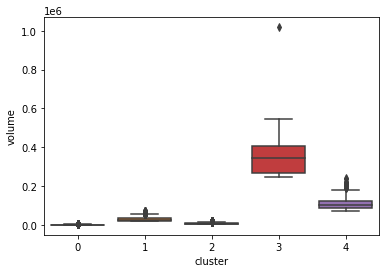

In [81]:
# plot
sns.boxplot(x='cluster', y='volume', data=rfm_df, )

In [86]:
rfm_df.groupby('cluster')['volume'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])

,count,mean,std,min,25%,50%,75%,90%,95%,max
cluster,,,,,,,,,,
0,321812.0,1088.456995,1132.349064,0.000000,201.603528,652.415864,1650.048931,2917.736317,3595.942285,4.600988e+03
1,3716.0,30841.673782,11730.966729,19504.150108,22168.623150,26438.633788,34994.590000,51230.958148,57806.334441,7.042345e+04
2,42292.0,8092.733473,3397.199050,4601.525343,5493.966875,6919.227961,9651.954758,13361.004855,15733.080000,1.950108e+04
3,16.0,382761.653523,187951.387385,248366.954952,269047.265867,343038.708000,405211.098000,485262.324000,663343.301250,1.018103e+06
4,285.0,110433.154789,33919.588027,71179.859337,85151.808000,100456.200000,125601.966000,156398.778656,180281.840100,2.397682e+05


In [110]:
rfm_df[(rfm_df['volume'] < 201.603528) & (rfm_df['volume'] < 1650.048931)].shape[0]/rfm_df.shape[0]

0.21853140679287517

In [127]:
rfm_df[(rfm_df['volume'] > 0) & (rfm_df['volume'] < 4000)].shape[0]/rfm_df.shape[0]

0.8507094134808935

In [105]:
rfm_df[(rfm_df['volume'] > 1650.048931) & (rfm_df['volume'] < 9651.954758)].shape[0]/rfm_df.shape[0]

0.3047150257659845

In [120]:
rfm_df[(rfm_df['volume'] > 1650.048931) & (rfm_df['volume'] < 9651.954758)].shape[0]/rfm_df.shape[0]

0.3047150257659845

In [122]:
kmeans.cluster_centers_

array([[-0.2039471 ],
       [ 4.84271967],
       [ 0.98517514],
       [64.43211578],
       [18.31325314]])

In [124]:
scaler.inverse_transform(kmeans.cluster_centers_)

array([[  1090.44659425],
       [ 30890.64339832],
       [  8112.12612356],
       [382761.6535226 ],
       [110433.15478872]])

In [125]:
rfm_df[(rfm_df['volume'] < 1090.44659425)].shape[0]/rfm_df.shape[0]

0.5564664879210912

In [126]:
rfm_df[(rfm_df['volume'] < 8112.12612356)].shape[0]/rfm_df.shape[0]

0.9477481588934074